# Convolutions

This notebook will do the following 
- Define convolutions in terms of the sliding window algorithm.
- Recognize common kernels for image convolution.
- Apply convolutions to recognize objects in an image.

your presuiqiste should be: being able to represenet/manipulat1e image matrix using numpy (refer to numpy -- HW version notebook)

In [1]:


import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np


def compare(*images):
    """Display one or more images side by side."""
    _, axs = plt.subplots(1, len(images), figsize=(15, 6)) # figureObj, axs = plt.subplot(1, len(images), figsize = (15,6))
    for ax, image in zip(axs, images):
        ax.imshow(image, cmap="gray")
#note: *images packing positional image arguments as parameter


### Convolution as mathmatical operators
($f$ and $g$) $(t) := \int^{\infty}_{-\infty}f(\tau)g(t-\tau)$

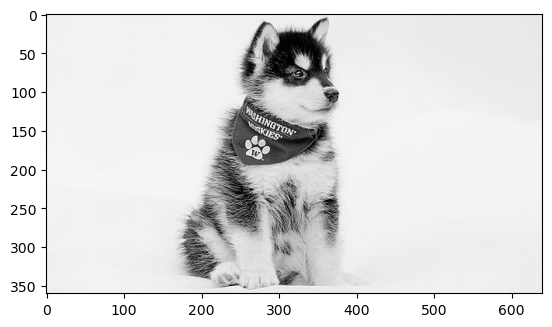

In [2]:
import os

dubs = iio.imread("dubs.jpg", mode="L")
plt.imshow(dubs, cmap="gray");

In this example, $g$ is a 3-by-3 [**box blur**](https://en.wikipedia.org/wiki/Box_blur) *kernel* that is applied to each patch or *subimage* in $f$, which is the image of our dub. 

$$g = \begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\[0.3em]
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\[0.3em]
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}
\end{bmatrix}$$

A **convolution** loops over an image one **subimage** (patch) at a time, until all subimages has been created through the looping. Convolutions are also often called "sliding window algorithms".

Here's how we can create this kernel in Python:

In [3]:
box_blur_3x3 = 1/9 *np.ones((3,3))


In [4]:
# Practce: Get Subimage
def get_subimages(image, kernel_shape):
    """Returns an array of subimages matching the given kernel shape."""
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel_shape
    subimages_h = image_h - kernel_h + 1 # recall subtraction ignore the 0 index case; +1 to normalize
    subimages_w = image_w - kernel_w + 1
    subimages = np.zeros((subimages_h, subimages_w, kernel_h, kernel_w))
    for ih in range(subimages_h):
        for iw in range(subimages_w):
            # subimages[ih, iw] = image[iw:iw + kernel_w,     ih:ih + kernel_h]
            # subimages[ih, iw] = image[iw:iw + kernel_w + 1, ih:ih + kernel_h + 1]
            subimages[ih, iw] = image[ih:ih + kernel_h,     iw:iw + kernel_w] 
            # subimages[ih, iw] = image[ih:ih + kernel_h + 1, iw:iw + kernel_w + 1]
    return subimages
# note: ih/iw goes from the lowest to the highest in the loop

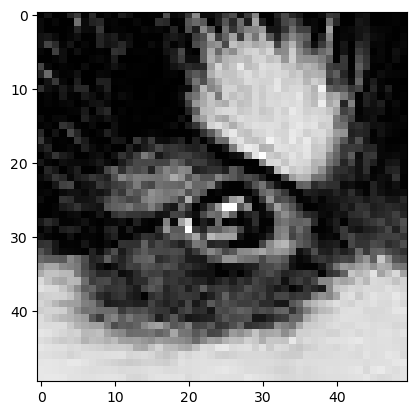

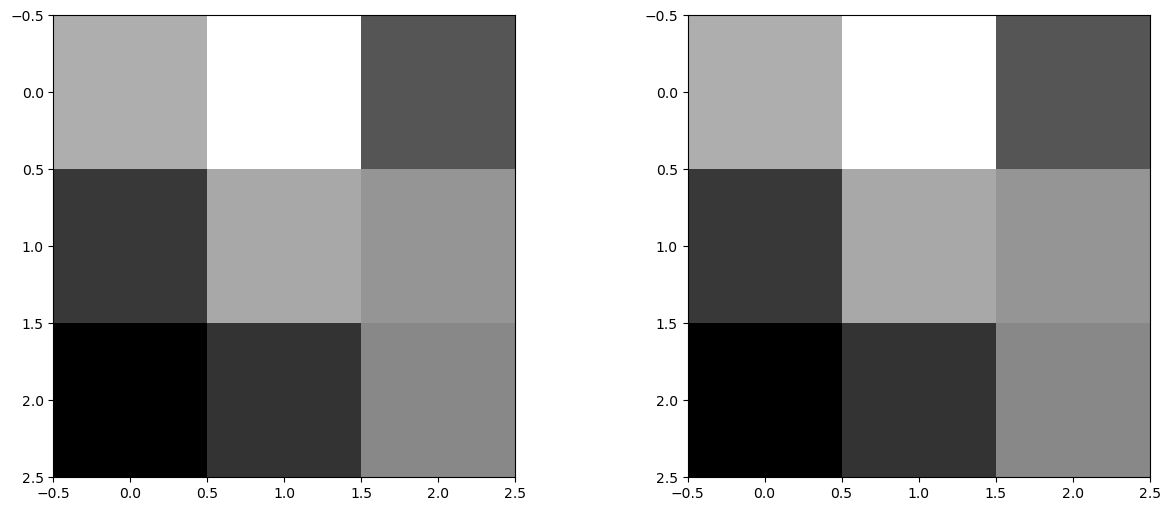

In [5]:
# lets plot the dub's eye using slicing
dubs_eye = dubs[50:100, 300:350]
plt.imshow(dubs_eye, cmap="gray");

# let plot it using sub_image function
dubs_eye_subimages = get_subimages(dubs_eye, (3, 3))

compare(dubs_eye_subimages[(30, 20)], dubs_eye[30:33, 20:23]) # compare the 3x3

# check if they are the same
assert np.allclose(dubs_eye_subimages[(30, 20)], dubs_eye[30:33,20:23])

### Practice: Sum of elemnt-wise products (convolution)
Write a NumPy expression to compute the sum of element-wise products between the current subimage and the given kernel.

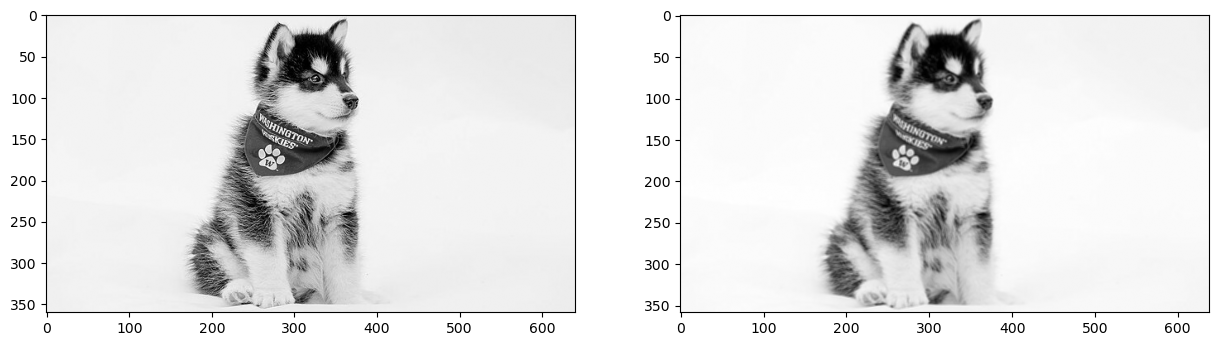

In [6]:
def convolve(image, kernel):
    """Returns the convolution of the image and kernel where the image shrinks by kernel shape."""
    subimages = get_subimages(image, kernel.shape)
    subimages_h, subimages_w = subimages.shape[:2] # first two elements from (subimages_h, subimages_w, kernel_h, kernel_w)
    result = np.zeros((subimages_h, subimages_w))
    for ih in range(subimages_h):
        for iw in range(subimages_w):
            result[ih, iw] = (subimages[ih, iw] * kernel).sum()  # convolution integral: the sum of the element-wise product
    return result


dubs_blurred = convolve(dubs, box_blur_3x3)
compare(dubs, dubs_blurred)

In [7]:
# selecting a larger and less sharpe kernel
box_blur_10x10 = np.ones((10, 10))
box_blur_10x10 /= box_blur_10x10.size # 1/100 for the 10x10

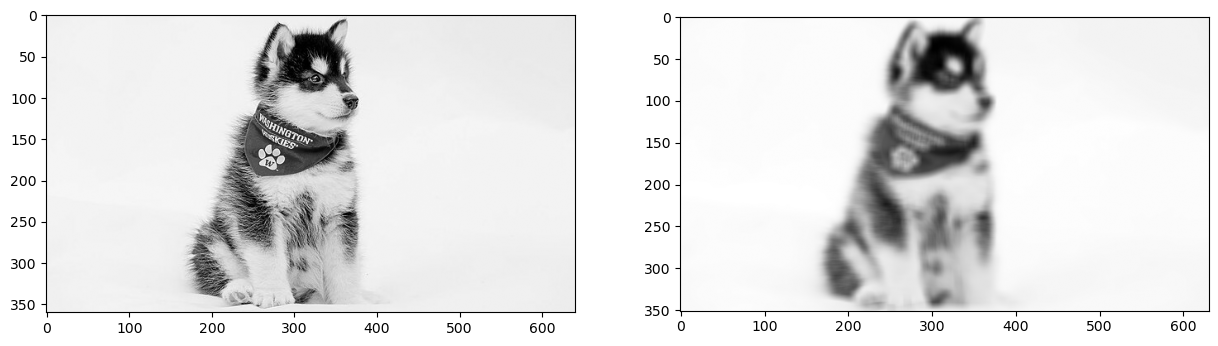

In [8]:
dubs_blurred_10x10 = convolve(dubs, box_blur_10x10)
compare(dubs, dubs_blurred_10x10)

### Understanding Kernels
- what are some kernel that exit? what can they do to an image?
- it basically reduce the sharpeness of the image

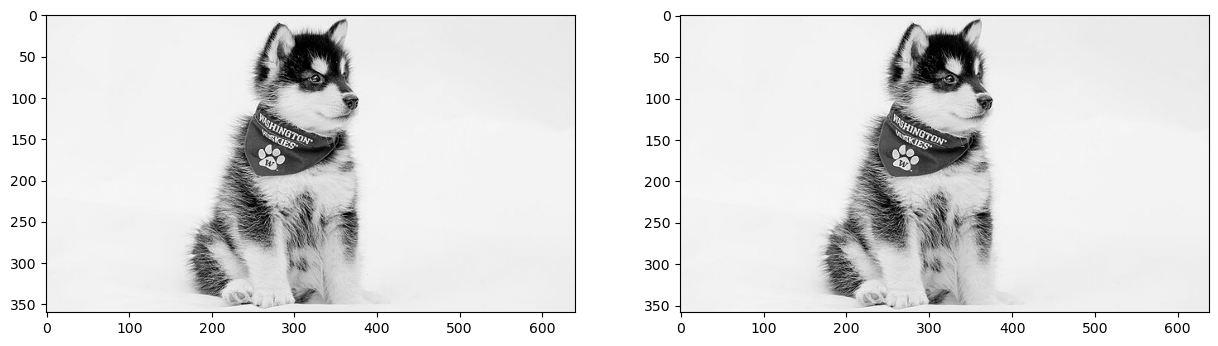

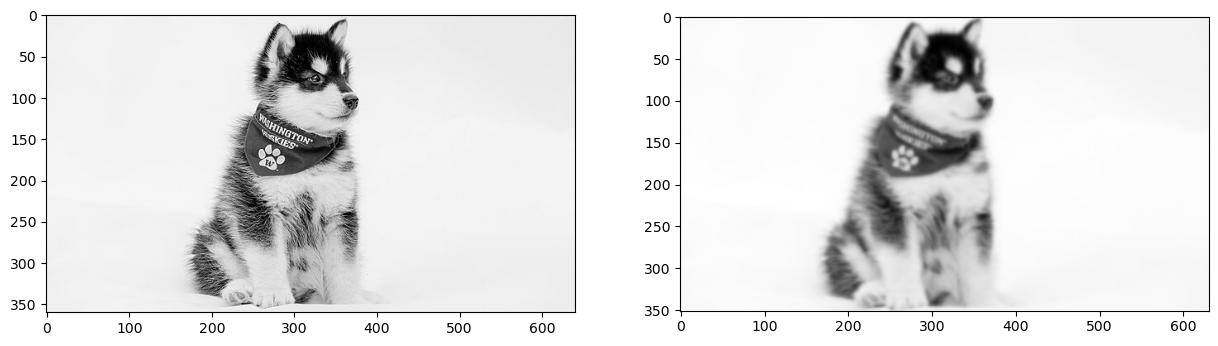

In [9]:
kernel = np.zeros((3, 3))
kernel[1, 1] = 1
kernel # a_11 = 1, else is 0

compare(dubs, convolve(dubs, kernel))



values = [[1, 2, 4, 7, 11, 11, 7, 4, 2, 1]]
kernel = np.array(values) * np.array(values).T
kernel = kernel / kernel.sum()
kernel.round(2)
compare(dubs, convolve(dubs, kernel))

### Practice: Template match

Write a function `template_match` that finds instances of a small template inside a larger image. Given an image and a template that can be found within it, `template_match` returns an array of values representing the pixel-by-pixel similarity between the template and each corresponding subimage.

This algorithm essentially applies a convolution over the image using the template as the kernel. However, using the raw pixel values will favor brighter pixels. Instead, we first have to de-mean both the template and the current subimage by subtracting the average pixel values.



/tmp/ipykernel_22035/4261428047.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[ih, iw] = similarity


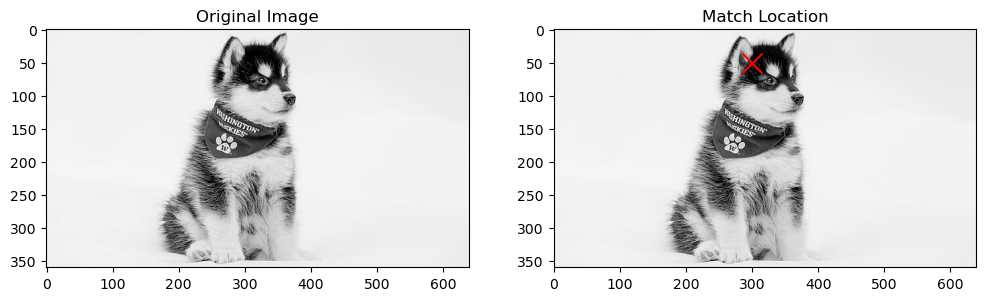

'some notes:\n1. unravel_index(): given an interger and a tuple, the integer mod from the -1 index and relay the integer devide remainder going down,\n producing resulting tuple shape ndarray\n2. ... palceholder is referred as  the elicpse object\n'

In [16]:
def template_match(image, template):
    """
    Given a grayscale image and template, returns a numpy array that stores the similarity of the
    template at each position in the image.
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    # De-mean the template
    demeaned_template = template - template.mean()

    # Construct result of the expected output size
    result = np.zeros((image_h - template_h + 1, image_w - template_w +1))
    result_h, result_w = result.shape

    for ih in range(result_h):
        for iw in range(result_w):
            # Select corresponding subimage
            subimage = image[ih:ih+template_h, iw:iw+template_w]

            # De-mean the subimage
            demeaned_subimage = subimage - subimage.mean()

            # Compute sum of element-wise products
            similarity = convolve(demeaned_subimage, demeaned_template)
            result[ih, iw] = similarity

    return result


match = template_match(dubs, dubs_eye)
compare(dubs, match)
#np.unravel_index(match.argmax(), match.shape)

'''some notes:
1. unravel_index(): given an interger and a tuple, the integer mod from the -1 index and relay the integer devide remainder going down,
 producing resulting tuple shape ndarray
2. ... palceholder is referred as  the elicpse object
'''